<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Daniel Quilodrán Acuña
- Nombre de alumno 2: Katherine Rutte Poblete


### **Link de repositorio de GitHub:** `https://github.com/quilo98/Labs_MDS`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [2]:
!pip install xgboost

In [3]:
# Librerias necesarias 
import pandas as pd
import numpy as np
import pandas as pd
import datetime as dt
from IPython.display import HTML
import joblib
#Libreria para plotear
import matplotlib.pyplot as plt

import os
import seaborn as sns
from scipy import stats
import re
import itertools
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier, plot_importance
import shutil
import random
import optuna
import time
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

In [4]:
def exploratory_data_analysis(dataframe):
    print("El dataframe contiene " + str(dataframe.shape[0])+ " filas y "  + str(dataframe.shape[1]) + " columnas")
    print("     ")
    print("Nombre de Columnas: " + str())
    display(dataframe.columns)
    print("     ")
    print("Primeros 5 elementos:")
    display(dataframe.head(5))
    print("     ")
    print("Últimos 5 elementos:")
    display(dataframe.tail(5))
    print("     ")
    print("Muestreo aleatorio 5 elementos:")
    display(dataframe.sample(5))
    print("     ")
    print("Descripción rápida dataframe:")
    print("     ")
    colums_num = dataframe.select_dtypes(include=['int64', 'float64'])
    display(colums_num.describe())
    print("     ")
    print("La cantidad de valores nulos en el dataframe es: ")
    display(dataframe.isna().sum())
    print("     ")
    print("Valores únicos en el dataframe por columna:")
    display(dataframe.nunique())
    print("     ")
    return

In [5]:
exploratory_data_analysis(df)

El dataframe contiene 70692 filas y 18 columnas
     
Nombre de Columnas: 


Index(['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP', 'Diabetes'],
      dtype='object')

     
Primeros 5 elementos:


,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


     
Últimos 5 elementos:


,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
70687,6.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0
70688,10.0,1.0,1.0,1.0,29.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
70689,13.0,0.0,1.0,1.0,25.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,15.0,0.0,1.0,0.0,1.0,1.0
70690,11.0,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,1.0
70691,9.0,0.0,1.0,1.0,25.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0


     
Muestreo aleatorio 5 elementos:


,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
65713,13.0,0.0,1.0,1.0,31.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0
762,5.0,0.0,0.0,1.0,25.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
26153,3.0,1.0,0.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
27071,3.0,0.0,0.0,1.0,23.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,15.0,0.0,0.0,0.0,0.0
49945,9.0,0.0,1.0,1.0,31.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0


     
Descripción rápida dataframe:
     


,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,8.584055,0.456997,0.525703,0.975259,29.856985,0.475273,0.147810,0.703036,0.611795,0.788774,0.042721,2.837082,3.752037,5.810417,0.252730,0.062171,0.563458,0.500000
std,2.852153,0.498151,0.499342,0.155336,7.113954,0.499392,0.354914,0.456924,0.487345,0.408181,0.202228,1.113565,8.155627,10.062261,0.434581,0.241468,0.495960,0.500004
min,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,1.000000,1.000000,29.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
75%,11.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000
max,13.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,1.000000,1.000000


     
La cantidad de valores nulos en el dataframe es: 


Age                     0
Sex                     0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Stroke                  0
HighBP                  0
Diabetes                0
dtype: int64

     
Valores únicos en el dataframe por columna:


Age                     13
Sex                      2
HighChol                 2
CholCheck                2
BMI                     80
Smoker                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Stroke                   2
HighBP                   2
Diabetes                 2
dtype: int64

In [6]:
# Inserte su código aquí
#Definimos X e y
X = df.drop(columns=["Diabetes"])
y =  df["Diabetes"]

#Dividimos los datos en conjuntos de entrenamiento (70%), validación (20%) y prueba (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

#Configuración el clasificador con un objetivo de clasificación binaria utilizando 10 árboles de decisión
xgb_classifier = XGBClassifier(objective = "binary:logistic", n_estimators = 10, seed = 42)

#Construcción del Pipeline
XGB_pipeline = Pipeline([
    ('regressor', xgb_classifier)
])

#Entrenamiento del modelo
XGB_pipeline.fit(X_train, y_train)

#Predicción sobre el conjunto de validación
y_val_pred = XGB_pipeline.predict(X_val)

#Calculo de accuracy y generación del informe para evaluar rendimiento del modelo
accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)

print(f'Accuracy en el conjunto de validación: {accuracy}')
print('Classification Report en el conjunto de validación:\n', classification_rep)

Accuracy en el conjunto de validación: 0.7519881765078471
Classification Report en el conjunto de validación:
               precision    recall  f1-score   support

         0.0       0.78      0.71      0.74      7143
         1.0       0.73      0.79      0.76      7066

    accuracy                           0.75     14209
   macro avg       0.75      0.75      0.75     14209
weighted avg       0.75      0.75      0.75     14209



### Respuesta
Se obtiene un accuracy del 74.2% en el conjunto de validación lo que indica que el modelo predice correctamente si es diabetico o no tres de cada cuatro veces. 
En cuanto a las métricas del conjunto de validación:
-   Precision: Se tiene una precision de 0.73 para la clase de diabéticos (clase 1) y 0.78 para la clase de no diabéticos (clase 0). Esto indica que el modelo predice mejor los no diabéticos que los diabéticos. 
-   Recall: Se tiene un recall de 0.79 para la clase de diabéticos y de 0.71 para la clase de no diabéticos. Recordamos que el recall mide cuantos casos reales de cada clase fueron capturados por el modelo, esto indica que el modelo es mejor detectando la clase 1.
- F1-score: Se tiene un F1-score de 0.76 para la clase 1 y de 0.74 para la clase 0, esto indica un equilibrio razonable entre precision y recall, aunque hay margen de mejora.

Con respecto a las métricas de rendimiento estas no proporcionan una visión directa si las características elegidas son las más informativas, es por ello que acontinuación se realizará un análisis de importancia de las features.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

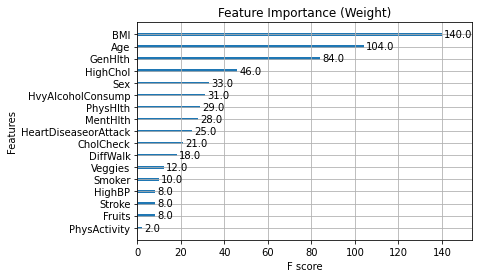

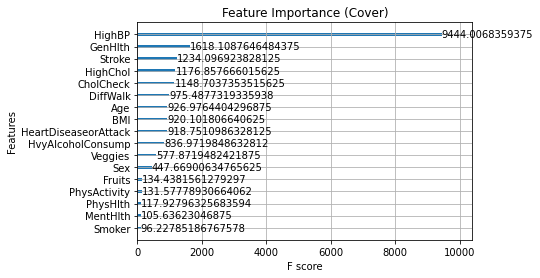

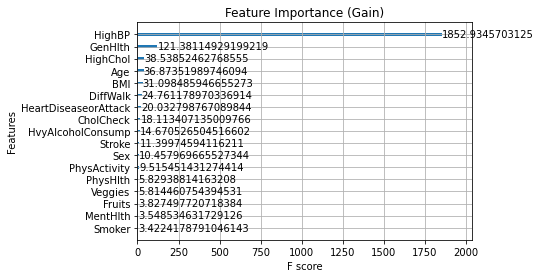

In [7]:
# Inserte su código aquí

# Calcular la importancia de las features
plot_importance(xgb_classifier, importance_type='weight', title='Feature Importance (Weight)')
plt.show()

plot_importance(xgb_classifier, importance_type='cover', title='Feature Importance (Cover)')
plt.show()

plot_importance(xgb_classifier, importance_type='gain', title='Feature Importance (Gain)')
plt.show()

### Respuesta
Primero es importante saber que representa cada método.
-   **Weight**: Mide la cantidad de veces que una característica aparece en los árboles de decisión dentro del modelo.
-   **Gain**: Mide la contribución promedio de una característica a la mejora del modelo cada vez que aparece en un árbol.
-   **Cover**: Mide el número promedio de muestras afectadas por las divisiones que involucran una característica.

Dado que estos métodos miden diferentes aspectos de la importancia de las características, es común que los resultados no sean consistentes entre ellos. Por ejemplo, una característica podría aparecer en muchos árboles (weight alto), pero no contribuir significativamente a la mejora del rendimiento del modelo (gain bajo), o afectar solo a un pequeño número de muestras (cover bajo). 
Si los métodos muestran diferentes características como importantes, esto no significa que los resultados sean incompatibles, sino que cada característica tiene un tipo diferente de impacto en el modelo. Por ejemplo, algunas características podrían ser críticas para hacer divisiones precisas en el árbol (alto gain), en este caso se observa que HighBP presenta un valor alto en este método, mientras que otras podrían ser útiles en más situaciones generales (alto weight o cover).
Se puede observar que HighBP presenta un valor alto para el método gain y cover lo que podria indicar que esta caracteristica sea relevante en el modelo.
En cuanto a las importancias obtenidas estas no son suficientes para darle interpretabilidad al modelo, para una interpretación más completa y mejor comprensión de la causalidad y la influencia de las características, será necesario implementar otras técnicas que permitan analizar la importancia de las características.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [8]:
# Inserte su código aquí
from sklearn.inspection import permutation_importance
result = permutation_importance(XGB_pipeline, X_test, y_test, n_repeats=30, random_state=42)

In [9]:
result

{'importances_mean': array([ 2.57322475e-02,  4.04819736e-04,  9.37276754e-03,  3.08139258e-03,
         3.74529695e-02,  1.57165309e-04,  1.99552317e-03,  4.76258513e-05,
         9.52517026e-05,  1.19540887e-03,  2.26222794e-03,  5.42696576e-02,
        -3.47668715e-04,  3.81006810e-04,  3.82911845e-03,  5.38172120e-04,
         1.93122827e-02]),
 'importances_std': array([2.42312637e-03, 7.90431320e-04, 1.74466696e-03, 6.79916368e-04,
        3.21220038e-03, 4.16310967e-04, 1.02000520e-03, 6.73531248e-05,
        1.74339241e-04, 5.60064622e-04, 7.11604172e-04, 3.41077248e-03,
        6.02443488e-04, 5.38824999e-04, 1.15804292e-03, 6.03571942e-04,
        2.94736305e-03]),
 'importances': array([[ 0.02900414,  0.02900414,  0.02400343,  0.02414631,  0.02857551,
          0.02386055,  0.02457494,  0.02657523,  0.02371767,  0.03043292,
          0.02386055,  0.02686098,  0.02086012,  0.02457494,  0.02857551,
          0.02900414,  0.02500357,  0.02443206,  0.02728961,  0.02414631,
     

In [10]:
var = ['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP', 'Diabetes']

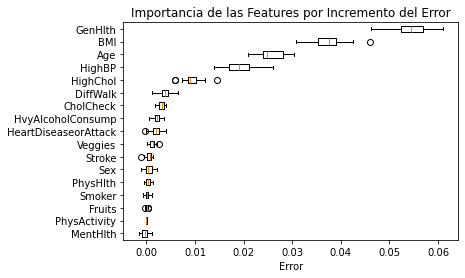

In [11]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(var)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

### Respuesta

El método mide la importancia de las características observando cuánto cambia el rendimiento del modelo cuando los valores de una caracteristica individual se permutan aleatoriamente en el conjunto de datos de prueba. Si la permutación de los valores de una característica lleva a un aumento significativo en el error de predicció, se considerará que la característica es importante para el modelo.

Con respecto al impacto de las features en el modelo, las 5 primeras corresponden a:
-   GenHlth: Esta variable indica la salud general del individuo. Tiene sentido de que tenga un gran impacto en el modelo ya que aquellas personas con una peor salud general pueden tener varios factores de riesgo para la diabetes.
-   BMI: Esta variable indica el índice de masa corporal. Un BMI alto está fuertemente relacionado con un mayor riesgo de desarrollar diabetes de tipo 2, lo que hace que esta característica sea un predictor lógico.
-   Age: Esta variable indica la edad del individuo. Esto tiene sentido ya que el riesgo de diabetes aumenta con la edad.
-   HighBP: Esta variable indica si el individuo tiene presión arterial alta o no. Esto tiene sentido ya que ambas condiciones (diabetes e hipertensión) pueden ser consecuencias de la obesidad y otros factores de estilo de vida no saludables.
-   HighChol: Esta variable indica si el individuo tiene el colesterol alto o no. Un nivel alto de colesterol es un conocido factor de riesgo cardiovascular que también puede estar asociado con la resistencia a la insulina (precursos de la diabetes)

En comparación a los resultados obtenidos en la sección anterior, hay algunas variables que aparacen en todos los métodos en los primeros lugares (HighBP y GenHlth), lo que podría indicar que estás variables si son de gran importancia para el modelo. Las 5 caracteristicas comentadas anteriormente están clínicamente relacionadas con la diabetes, lo que respalda la validez del modelo desde una perspectiva médica.

En cuanto a las ventajas y desventajas se tiene que:
-   Ventajas: 
    -   Evaluación basada en el rendimiento: La permutación ofrece una perspectiva del impacto real en el rendimiento del modelo en el conjunto de datos de prueba, proporcionando una medida de importancia basada en la evidencia.
    -   Robustez contra el overfitting: La permutación permite ayudar a identificar si el modelo se ha sobreajustado a patrones particulares en los datos de entrenamiento.
    -   Facilidad de interpretación: Los resultados son fáciles de interpretar y comunicar a los interesados.
-   Desventajas:
    -   Costo computacional: La permutación requiere muchas evaluaciones del modelo, lo que puede ser costoso en términos de tiempo y recursos computacionales.
    -   Posible ruido en los datos de prueba: Si los datos de prueba no son representativos de la población general, los resultados podrian llegar a ser engañosos.
    -   No captura interacciones complejas: La permutación de una sola caracteristica a la vez puede no reflejar la importancia de las interacciones entre características.


## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [12]:
!pip install shap

  Using cached shap-0.43.0-cp39-cp39-win_amd64.whl (447 kB)


In [13]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [15]:
# Inserte código para calcular shapley values aquí
import shap
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer(X)
shap_values

[22:15:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


.values =
array([[-0.85687006, -0.00787974, -0.4128558 , ..., -0.06236175,
        -0.00488613,  0.5316394 ],
       [ 0.20516159,  0.05939708,  0.18613009, ..., -0.04695287,
         0.09509048,  0.42817467],
       [ 0.77058727,  0.23089279, -0.14716007, ..., -0.03799138,
        -0.00684959, -0.5149412 ],
       ...,
       [ 0.12026523, -0.00558772,  0.13941878, ...,  0.1300637 ,
        -0.0033271 ,  0.48131776],
       [ 0.16712359, -0.04132102,  0.2617458 , ...,  0.10970003,
        -0.020875  ,  0.52715194],
       [ 0.10548148, -0.05337601,  0.13753615, ..., -0.09103481,
        -0.01096817,  0.5627964 ]], dtype=float32)

.base_values =
array([-0.00863698, -0.00863698, -0.00863698, ..., -0.00863698,
       -0.00863698, -0.00863698], dtype=float32)

.data =
array([[ 4.,  1.,  0., ...,  0.,  0.,  1.],
       [12.,  1.,  1., ...,  0.,  1.,  1.],
       [13.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  1., ...,  1.,  0.,  1.],
       [11.,  0.,  1., ...,  1.,  0.

#### Respuesta
Los numeros de los resultados representan lo siguiente:
-   .values: Matriz que contiene los SHAP values para cada característica de la muestra. Cada valor en esta matriz representa el impacto de una característica en la predicción del modelo para una muestra individual.
-   .base_values: Valor base o de referencia que SHAP usa para las predicciones. Corresponde a la prediccion que el modelo haria si no tuviera información sobre las características actuales de la muestra. Puede interpretarse como la expectativa del modelo antes de conocer cualquier característica.
-   .data: Matriz que contiene los datos reales de las muestras que fueron analizadas. Cada fila corresponde a una muestra individual y cada columna a una característica.

Con respecto a la positividad/negatividad de cada valor si es posible atribuirle un significado. En este caso. Un valor positivo indica que la presencia de la característica empuja la predicción del modelo hacia un resultado positivo (en este contexto, seria hacia la clase 1), mientras que un valor negativo indica que la característica empuja la predicción hacia la clase negativa (clase 0). Esta intepretación permite entender por qué el modelo tomó una decisión particular para una muestra individual.

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

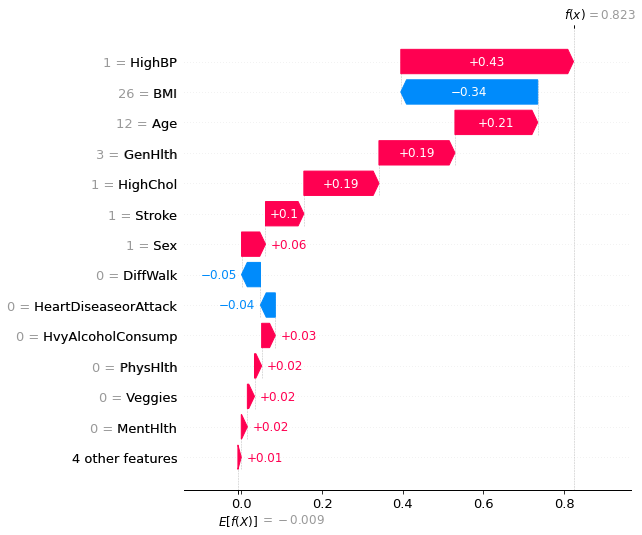

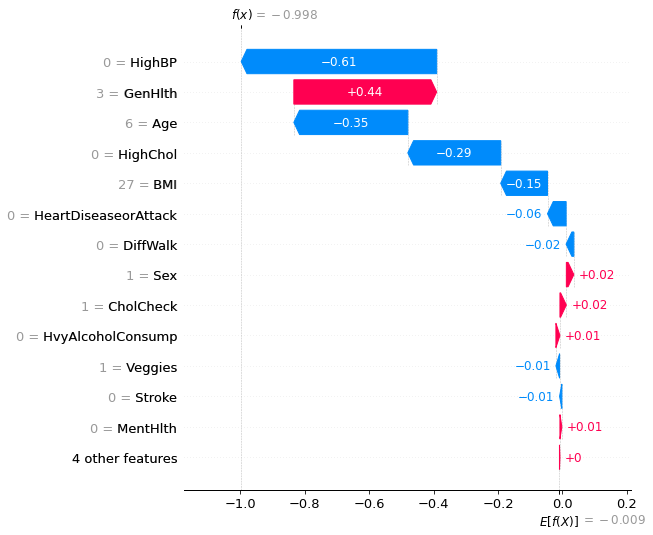

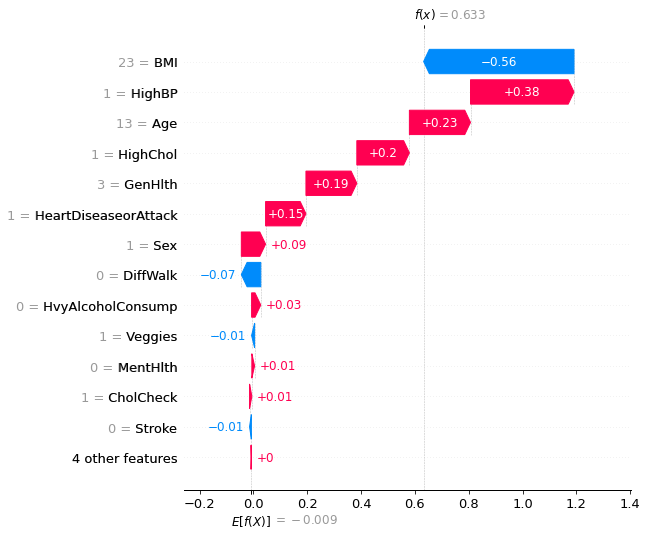

In [17]:
# Inserte código para generar gráficos de aporte local aquí
idx=1
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

idx=9
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

idx=150
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

#### Respuesta
Las barras rojas indican un efecto positivo en la predicción de la clase de interés (clase 1), lo que significa que estas características aumentan la probabilidad de que la instancia sea clasificada como positiva para diabetes.
Las barras azules indican un efecto negativo en la predicción de la clase, lo que estas características disminuyen la probabilidad de la clasificación positiva para diabates.

Con respecto a cada instancia:
-   Instancia 1: Presenta una alta probabibilidad de tener diabetes, siendo la presencia de un alto nivel de presión arterial una de las variables que incrementa la probabilidad de tener diabetes.
-   Instancia 9: Presenta una baja probabilidad de tener diabetes, siendo la ausencia de un nivel de presión arterial alto una de las variables que disminuye la probabilidad de tener diabetes, sin embargo presenta un nivel medio de salud general lo que incrementa la probabilidad de tener diabetes.
-   Instancia 150:  Presenta una probabilidad relativamente alta de tener diabetes, esta probabilidad disminuye debido a su BMI que se encuentra en los rangos de una persona saludable, pero aumenta debido a que presenta una alta presion arterial.

Más en detalle las variables que afectan de manera positiva, es decir que aumentan la probabilidad de presentar diabetes son  (para cada instancia):
-   Instancia 1: Alta presión arterial (HighBP=1), la edad (12), salud general media (GenHlth=3), colesterol alto (HighChol=1), stroke (stroke =1), sexo (sex=1), entre otras.
-   Instancia 9: Baja salud general (GenHlth=3)
-   Instancia 150: Alta presión arterial (HighBP = 1), edad (age=13), colesterol alto (HighChol=1), salud general media (GenHelth=3) y haber tenido un ataque cadíaco (HeartDiseasorAttack = 1), entre otras.

Las variables que afectan de manera negativa, es decir que disminuyen la probabilidad de tener diabetes son:
-   Instancia 1: Presentar un BMI cerca del rango de una persona saludable (cuando el BMI está entre 18.5 y 25 la persona esta saludable), entre otras que afectan de menor manera 
-   Instancia 9: No tener la presión arterial alta (HighBP=0), edad (age=6), no tener el colesterol alto (HighChol = 0) y un BMI de 27, entre otras.
-   Instancia 150: Presentar un BMI de 23 es la variable disminuye con mayor fuerza la probabilidad de tener diabetes.

Se puede observar que si hay patrones en las instancias, ya que ambas instancias que presentan una alta probabilidad de tener diabetes comparten las variables que afectan de manera positiva a esta probabilidad. Por ejemplo, se puede observar que tener la presión arterial alta y el colesterol alto incrementan la probabilidad de tener diabetes.


Si bien estas interpretaciones individuales son valiosas para entender las decisiones del modelo a nivel paciente, no siempre se pueden generalizar a todo el conjunto de datos, estas tendencias observadas pueden no sostenerse cuando se consideran todos los datos




### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

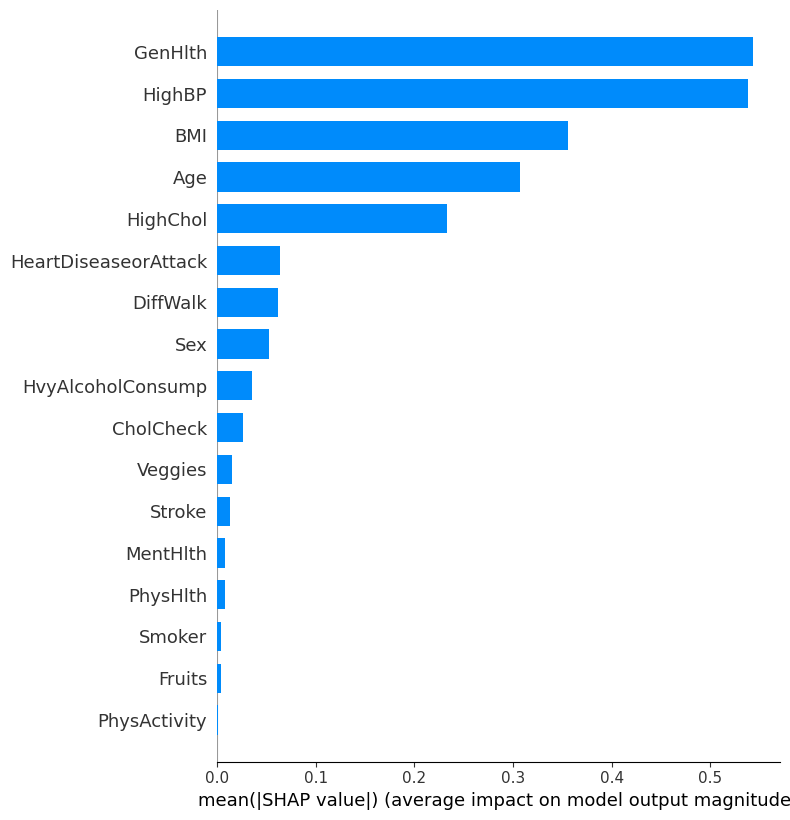

In [16]:
# Inserte código para generar gráficos de aporte global aquí
shap.summary_plot(shap_values, X, plot_type="bar")

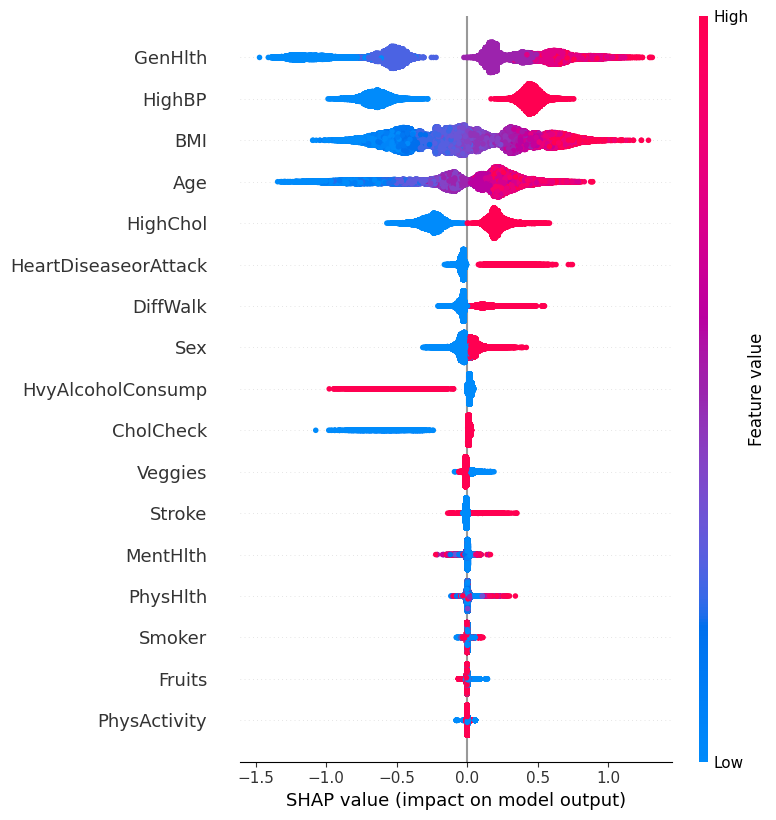

In [17]:
# Otra forma der ver el plot anterior es la siguiente
shap.summary_plot(shap_values, X)

### Respuesta
En estos gráficos se puede observar a nivel general como afecta cada feature en la predicción del modelo. Se puede observar que la variable que indica la salud general del individuo es la que impacta de mayor manera al modelo, los valores muy altos tienden a aumentar la probabilidad de tener diabetes y los valores bajos la disminuyen (esta variable tiene 5 valores, donde se podria interpretar que el nivel 1 representa a una persona sana y el 5 lo contrario). La sigue la variable HighBP que indica si un individuo tiene la presión arterial alta o no, la presencia de hipertensión tiende a aumentar la probabilidad de tener diabetes y la ausencia la disminuye. En tercer lugar se encuentra la variable BMI, un valor alto tiende a aumentar la probabilidad de presentar diabtes y uno bajo la dismuye. Luego se tiene la variable Age, a medida que la edad aumenta, la probabilidad de presentar diabetes se incrementa. Por último mencionamos la variable HighChol que indica si se tiene el colesterol alto o no, la presencia de un colesterol alto aumenta la probabilidad de tener diabetes y la ausencia la disminuye.
Estas 5 variables son las que impactan de mayor forma la predicción del modelo.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

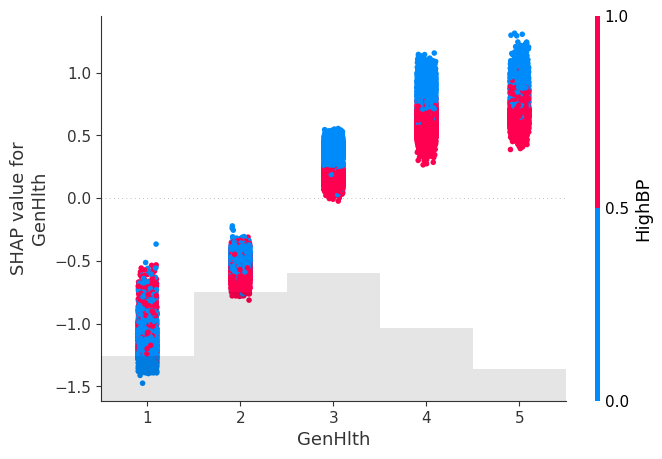

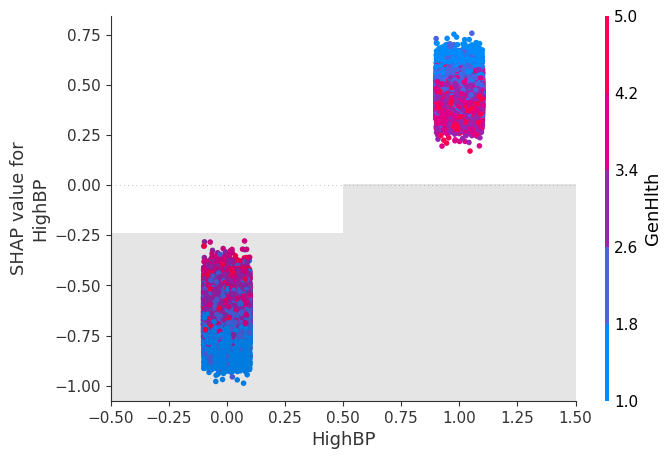

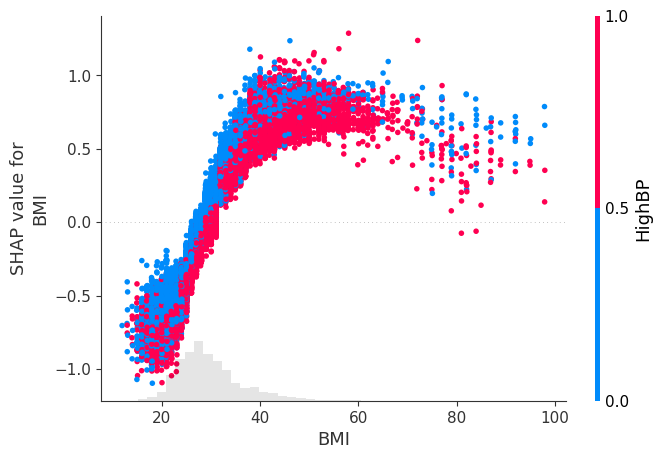

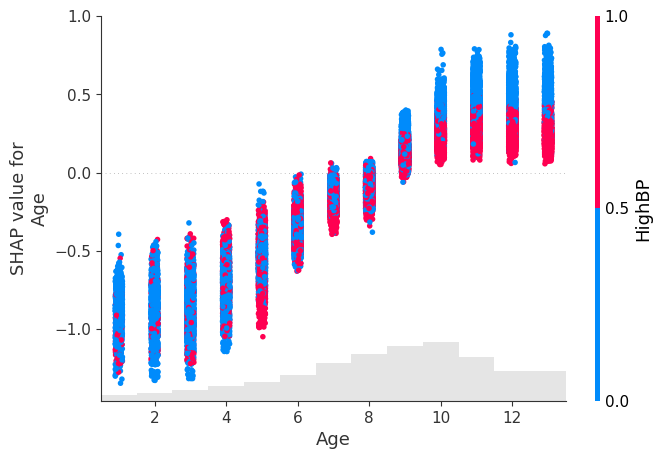

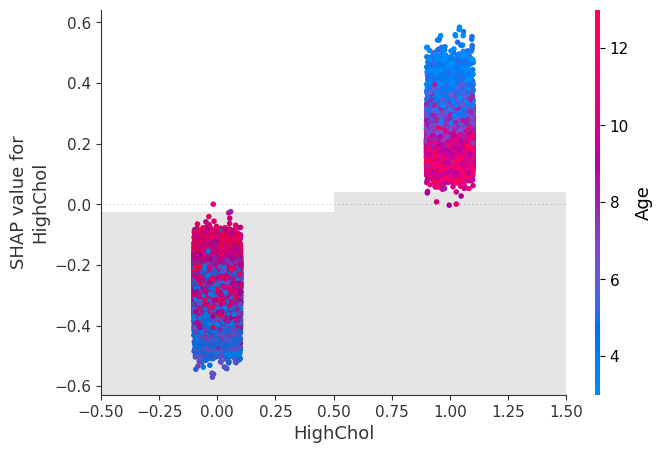

In [18]:
# Inserte código para generar gráficos de feature vs shap value aquí
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]
# Seleccionamos las 5 mas importante
for name in feature_importance_names[:5]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], 
                   color=shap_values)



En general los resultados anteriores coinciden con la interpretación realizada en la sección anterior

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

In [18]:
import matplotlib
print(matplotlib.__version__)

3.8.1


In [20]:
# GenHtlh
# HighBP
# BMI
# HighChol

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

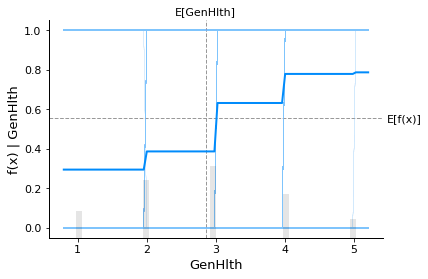

In [20]:
#Inserte código para generar gráficos PDP aquí
X1000 = shap.utils.sample(X, 1000)
sample_ind = 150

shap.partial_dependence_plot(
    'GenHlth', xgb_classifier.predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

# shap.partial_dependence_plot(
#     'HighBP', xgb_classifier.predict, X1000, model_expected_value=True,
#     feature_expected_value=True, ice=True,
#     shap_values=shap_values[sample_ind:sample_ind+1,:]
# )

# shap.partial_dependence_plot(
#     'BMI', xgb_classifier.predict, X1000, model_expected_value=True,
#     feature_expected_value=True, ice=True,
#     shap_values=shap_values[sample_ind:sample_ind+1,:]
# )

# shap.partial_dependence_plot(
#     'Age', xgb_classifier.predict, X1000, model_expected_value=True,
#     feature_expected_value=True, ice=True,
#     shap_values=shap_values[sample_ind:sample_ind+1,:]
# )

# shap.partial_dependence_plot(
#     'HighChol', xgb_classifier.predict, X1000, model_expected_value=True,
#     feature_expected_value=True, ice=True,
#     shap_values=shap_values[sample_ind:sample_ind+1,:]
# )

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

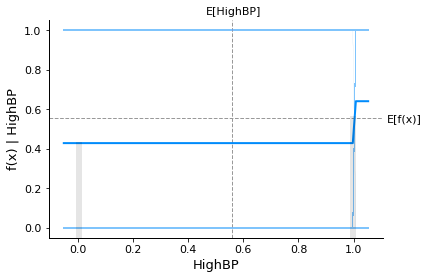

In [24]:
shap.partial_dependence_plot(
    'HighBP', xgb_classifier.predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

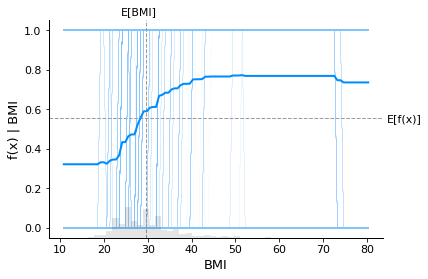

In [25]:
shap.partial_dependence_plot(
    'BMI', xgb_classifier.predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

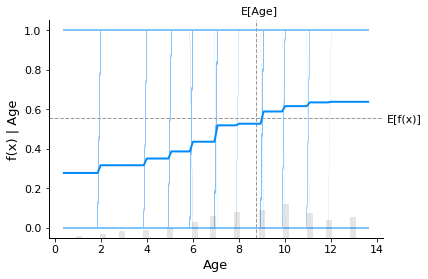

In [26]:
shap.partial_dependence_plot(
    'Age', xgb_classifier.predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

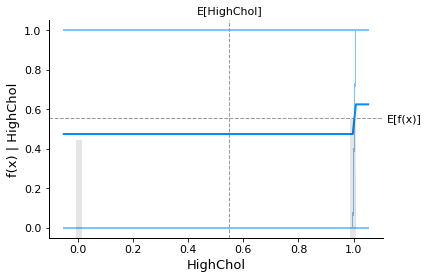

In [27]:
shap.partial_dependence_plot(
    'HighChol', xgb_classifier.predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [21]:
!pip install alibi

In [22]:
from alibi.explainers import AnchorTabular

In [23]:
# Inserte su código para generar sistema de reglas aquí
predict_fn = lambda x: xgb_classifier.predict(x)
explainer = AnchorTabular(predict_fn, xgb_classifier.feature_names_in_, seed=42)
explainer.fit(X_train.to_numpy())
class_names = ["Paciente_no_Diabetico", "Paciente_Diabetico"]
idx = 1000
# explicar predicción idx 1000



print("ID=1000")
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
idx = 3001
# explicar predicción idx 3001
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print("ID=3001")
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
idx = 5751
# explicar predicción idx 5751
print("ID=5751")
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)


total_population_covered = explanation['data']['raw']['coverage'][0]
print('Total Population Covered: %.2f%%' % (total_population_covered * 100))

# Obtener predicciones del modelo en el conjunto de prueba
all_predictions = explainer.predictor(X_test.to_numpy())

# Calcular la precisión global
accuracy = np.mean(all_predictions == y_test)
print('Accuracy total del modelo: %.2f' % accuracy)

ID=1000
Prediction:  Paciente_Diabetico
Anchor: GenHlth > 3.00 AND HighBP > 0.00
Precision: 0.96
Coverage: 0.21
ID=3001
Prediction:  Paciente_Diabetico
Anchor: GenHlth > 3.00 AND HeartDiseaseorAttack > 0.00
Precision: 0.99
Coverage: 0.08
ID=5751
Prediction:  Paciente_Diabetico
Anchor: GenHlth > 3.00 AND BMI > 33.00
Precision: 0.96
Coverage: 0.10
Total Population Covered: 26.40%
Accuracy total del modelo: 0.75


The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.


### Respuesta
Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

Se tienen las siguientes reglas:
- Para el ID 1000, la regla es que si 'GenHlth' es mayor a 3 y 'HighBP' es mayor a 0, entonces la predicción es "Paciente Diabético" con una precisión del 96% y una cobertura del 21%.
- Para el ID 3001, la regla incluye 'GenHlth' mayor a 3 y 'HeartDiseaseorAttack' mayor a 0, con una precisión del 99% pero con una cobertura menor del 8%.
- Para el ID 5751, la regla involucra 'GenHlth' mayor a 3 y 'BMI' mayor a 33, con una precisión del 96% y una cobertura del 10%.

La población a la que se pueden aplicar estas reglas es del 26.4%, lo que significa que estas condiciones solo se aplican a un poco más de una cuarta parte del conjunto de prueba.La precisión de las reglas es alta (96-99%), lo que significa que cuando se aplican estas reglas, hay una alta probabilidad de que las predicciones sean correctas.

Las reglas tienen sentido desde una perspectiva clínica. 'GenHlth' (salud general) es un indicador general del estado de salud de una persona, y una puntuación alta podría estar asociada con diversas condiciones médicas, incluida la diabetes.'HighBP' (alta presión sanguínea) y 'HeartDiseaseorAttack' (enfermedad cardíaca o ataque) están clínicamente relacionados con la diabetes, ya que la diabetes es un factor de riesgo para enfermedades cardíacas y viceversa.Un 'BMI' alto es un factor de riesgo conocido para la diabetes tipo 2, lo que justifica su inclusión en la regla para el ID 5751.

Si bien las reglas son precisas, la cobertura varía (8-21%), lo que significa que no todas las instancias en el conjunto de datos se explican con estas reglas. Esto es común, ya que las condiciones que son muy específicas. La precisión global del modelo es del 75%, lo que indica que, aunque las reglas son precisas, no necesariamente capturan todos los casos en los que el modelo es capaz de hacer una predicción correcta.


# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí
Considerando que es un problema asociado a la salud de las personas, lo más adecuado sería trabajar con métodos locales, ya que buscamos predecir una condición (probabilidad de tener diabetes), de acuerdo al historial médico individual. Si bien los métodos globales nos dan una idea de como afectan las variables a la predicción, los métodos locales nos permiten conocer individualmente como afecta el valor de cada feature en la predicción de la probabilidad de tener diabetes.
Un modelo predictivo fuerte como XGBoost para hacer la predicción y luego SHAP o AnchorTabular  sirven para interpretar y explicar las predicciones. Las explicaciones locales brindadas por SHAP y Alibi son especialmente útiles en el contexto clínico, ya que proporcionan explicaciones comprensibles y basadas en la evidencia que pueden ser comunicadas a los pacientes para ayudarles a entender su riesgo individual y qué aspectos de su historial médico son más pertinentes para su situación actual.

In [28]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>